# Creating and manipulating monte carlo spectra using MITK-MSI

In this tutorial we will learn how to
1. create reflectance spectra from examplary tissues
2. how to analyse and visualize the created spectra
3. how to manipulate them

The MITK-MSI software provides a wrapper to the popular MCML approach to simulate how light travels through tissue. This wrapper can be found in mc/sim.py.
In this tutorial we will utilize our tissue model which uses this wrapper to create the reflectance spectra.

As a prerequisit, you need a MCML monte carlo simulation which uses the format specified [here](http://omlc.org/software/mc/).
I tested this software with the GPU accelerated version which can be found [here](https://code.google.com/archive/p/gpumcml/).

In [1]:
# 1.1 create spectra - setup simulation environment

# some necessary imports
import logging
import numpy as np
import os
# everything related to the simulation wrapper
from mc import sim
# the factories create batches (tissue samples) and suited tissue models
from mc import factories
# the tissueparser reads a tissue init file
# examples can be found in mc/data/tissues
from mc import tissueparser

# Where does your monte carlo simulation executable resides in?
MCML_EXECUTABLE = "/home/wirkert/workspace/monteCarlo/gpumcml/fast-gpumcml/gpumcml.sm_20"
# The wavelengths for which we want to run our simulation
WAVELENGTHS = np.arange(450, 978, 2) * 10 ** -9
# how many spectra do you want to simulate:
NR_ELEMENTS_IN_BATCH = 10
# number of batch to simulate
BATCH_NR = 0
# batch_prefix
BATCH_PREFIX = "tutorial_batch"
# the file where the tissue is specified.
# switch out this file with your tissue specification to 
# create samples from a different tissue spec.
TISSUE_CONFIG_FILE = "../mc/data/tissues/laparoscopic_ipcai_colon_2016_08_23.ini"
# The MCML needs a simulation input file, where shall it be created?
MCI_FILENAME = "./" + BATCH_PREFIX + "_" + str(BATCH_NR) + ".mci"

# we want to create standard colonic tissue as specified in the IPCAI 2016 publication
# "Robust Near Real-Time Estimation of Physiological Parameters from Megapixel
# Multispectral Images with Inverse Monte Carlo and Random Forest Regression"
factory = factories.GenericMcFactory()

# create a simulation wrapper
sim_wrapper = sim.SimWrapper()
# our simulation needs to know where the input file for the simulation
# shall resign (will be automatically created)
sim_wrapper.set_mci_filename(MCI_FILENAME)
# also it needs to know where the simulation executable shall lie in
sim_wrapper.set_mcml_executable(MCML_EXECUTABLE)

# create the tissue model
# it is responsible for writing the simulation input file
tissue_model = factory.create_tissue_model()
# tell it where the input file shall lie in
tissue_model.set_mci_filename(sim_wrapper.mci_filename)
# tell it how much photons shall be simulated. Will be set to 10**6 by standard,
# this is just an example
tissue_model.set_nr_photons(10**6)
# enter total number of simulations for mci file generation
total_nr_mc_simulations = NR_ELEMENTS_IN_BATCH * len(WAVELENGTHS)
tissue_model._mci_wrapper.set_nr_runs(total_nr_mc_simulations)            
# create the header for the mci file
tissue_model.create_mci_file()

In [3]:
# 1.2 create spectra - create tissue samples for simulation

# create a tissueparser which reads the tissue in the ini file
tissue_instance = tissueparser.read_tissue_config(TISSUE_CONFIG_FILE)

# setup batch with tissue instances which should be simulated
batch = factory.create_batch_to_simulate()
# tell the batch whcih tissue it should create samples from
batch.set_tissue_instance(tissue_instance)
# we want to simulate ten tissue instances in this example
df = batch.create_tissue_samples(NR_ELEMENTS_IN_BATCH)

# lets have a look at the dataframe. Each row corresponds to one tissue instance,
# each tissue instance is defined by various layers, which all have certain parameters
# like e.g. oxygenation (here sao2)
df

layer0                                                            layer1  \
       sao2       vhb        a_mie  b_mie         g     n         d      sao2   
0  0.632633  0.000826  1560.819070  1.286  0.848471  1.36  0.000673  0.632633   
1  0.409270  0.053979  1558.674039  1.286  0.899525  1.36  0.000709  0.409270   
2  0.943907  0.067867  1667.427810  1.286  0.840631  1.36  0.000711  0.943907   
3  0.909812  0.039424  2828.281580  1.286  0.919210  1.36  0.000654  0.909812   
4  0.344822  0.009769   570.164980  1.286  0.908733  1.36  0.000757  0.344822   
5  0.873760  0.056655  2941.741417  1.286  0.809546  1.36  0.000640  0.873760   
6  0.553517  0.068282  2561.404164  1.286  0.930675  1.36  0.000913  0.553517   
7  0.418022  0.044325  1201.603582  1.286  0.890671  1.36  0.000939  0.418022   
8  0.973481  0.093912   996.414682  1.286  0.869200  1.36  0.000715  0.973481   
9  0.417810  0.082190  4072.986886  1.286  0.837910  1.36  0.000880  0.417810   

                            ...                                 layer2  \
        vhb        a_mie    ...            g     n         d      sao2   
0  0.079031  1406.323922    ...     0.876187  1.36  0.000446  0.632633   
1  0.053748  2619.443606    ...     0.827525  1.36  0.000439  0.409270   
2  0.073285  2008.587500    ...     0.801445  1.36  0.000803  0.943907   
3  0.074481   791.233524    ...     0.940623  1.36  0.000756  0.909812   
4  0.066852   807.497924    ...     0.934766  1.36  0.000462  0.344822   
5  0.003399  2217.922134    ...     0.814214  1.36  0.000493  0.873760   
6  0.019014  3442.865748    ...     0.927778  1.36  0.000524  0.553517   
7  0.059441  3649.474258    ...     0.924648  1.36  0.000559  0.418022   
8  0.092696  1358.198351    ...     0.915904  1.36  0.000536  0.973481   
9  0.036174  3257.372088    ...     0.855074  1.36  0.000552  0.417810   

                                                            
        vhb         a_mie  b_mie         g     n         d  
0  0.009865  1.014556e+03  1.286  0.867916  1.38  0.000520  
1  0.009009  1.967338e+03  1.286  0.897950  1.38  0.000404  
2  0.063552  1.818446e+03  1.286  0.802089  1.38  0.000476  
3  0.024295  8.209866e+02  1.286  0.875227  1.38  0.000476  
4  0.078719  3.200061e+03  1.286  0.857220  1.38  0.000582  
5  0.016307  3.541937e+03  1.286  0.837881  1.38  0.000487  
6  0.036058  1.263267e+03  1.286  0.938123  1.38  0.000495  
7  0.068284  2.586234e+03  1.286  0.937753  1.38  0.000568  
8  0.063565  1.703655e+03  1.286  0.907510  1.38  0.000445  
9  0.040051  1.000000e-10  1.286  0.850733  1.38  0.000400  

[10 rows x 21 columns]

In [4]:
# 1.3 create spectra - run simulation

# add reflectance column to dataframe
for w in WAVELENGTHS:
    df["reflectances", w] = np.NAN # the reflectances have not been calculated yet, thus set no nan

# small helper function to create mco filenames:
def _create_mco_filename_for(prefix, batch, simulation):
    return str(prefix) + "_Bat_" + str(batch) + "_Sim_" + str(simulation) + "_"

for i in range(df.shape[0]):
    # set the desired element in the dataframe to be simulated
    base_mco_filename = _create_mco_filename_for(BATCH_PREFIX,
                                                 BATCH_NR,
                                                 i)
    tissue_model.set_base_mco_filename(base_mco_filename)
    tissue_model.set_tissue_instance(df.loc[i, :])
    tissue_model.update_mci_file(WAVELENGTHS)

# Run simulations for the created mci file
sim_wrapper.run_simulation()

# get information from created mco files
for i in range(df.shape[0]):
    for wavelength in WAVELENGTHS:
        # for simulation get which mco file was created
        simulation_path = os.path.split(sim_wrapper.mcml_executable)[0]
        base_mco_filename = _create_mco_filename_for(BATCH_PREFIX,
                                                     BATCH_NR,
                                                     i)
        mco_filename = base_mco_filename + str(wavelength) + '.mco'
        # get diffuse reflectance from simulation
        df["reflectances", wavelength][i] = \
            sim.get_diffuse_reflectance(os.path.join(simulation_path, mco_filename))
        # delete created mco file
        os.remove(os.path.join(simulation_path, mco_filename))

# Hooray, finished,
# now our dataframe also contains reflectances for each tissue instance:
df["reflectances"]

,4.5e-07,4.52e-07,4.54e-07,4.56e-07,4.58e-07,4.6e-07,4.62e-07,4.64e-07,4.66e-07,4.68e-07,...,9.58e-07,9.6e-07,9.62e-07,9.64e-07,9.66e-07,9.68e-07,9.7e-07,9.72e-07,9.74e-07,9.76e-07
0,0.240736,0.250075,0.259669,0.262666,0.266424,0.268624,0.272470,0.273566,0.277570,0.279579,...,0.323101,0.321796,0.321904,0.321119,0.321113,0.321854,0.320796,0.320576,0.320410,0.321175
1,0.031429,0.047173,0.068496,0.077790,0.085776,0.092815,0.101203,0.105925,0.112666,0.119245,...,0.363523,0.362616,0.363345,0.363140,0.363124,0.364390,0.364102,0.363467,0.364316,0.363748
2,0.037307,0.041135,0.046615,0.050779,0.053062,0.056161,0.060896,0.063116,0.067304,0.071471,...,0.334647,0.334209,0.334939,0.333843,0.334432,0.333872,0.334073,0.333934,0.334663,0.334896
3,0.106211,0.116545,0.128593,0.136098,0.141106,0.147065,0.154743,0.158064,0.164943,0.170874,...,0.330942,0.330938,0.331425,0.330057,0.329895,0.330551,0.330288,0.329599,0.330208,0.329932
4,0.045253,0.059170,0.078182,0.085340,0.092213,0.097792,0.104661,0.108863,0.113748,0.118478,...,0.335171,0.335349,0.336433,0.336281,0.336849,0.337842,0.337472,0.338436,0.337971,0.338129
5,0.079994,0.090796,0.104132,0.112267,0.117250,0.124375,0.131922,0.136643,0.144635,0.151564,...,0.434711,0.433997,0.433875,0.434208,0.434262,0.433247,0.433803,0.432649,0.433546,0.433745
6,0.045271,0.062191,0.081795,0.090644,0.097037,0.104194,0.112088,0.116443,0.123439,0.129714,...,0.419979,0.419490,0.420587,0.420406,0.420410,0.420200,0.421382,0.421416,0.421318,0.421338
7,0.029435,0.044109,0.064581,0.073095,0.080804,0.087453,0.095597,0.100788,0.106941,0.113025,...,0.410311,0.410687,0.410913,0.411389,0.412318,0.412895,0.413372,0.413703,0.413904,0.414285
8,0.013784,0.015119,0.017091,0.018809,0.019671,0.021220,0.023059,0.024007,0.026018,0.028067,...,0.250787,0.250616,0.250110,0.250274,0.250117,0.249518,0.250900,0.249764,0.249802,0.250050
9,0.058828,0.083144,0.112805,0.124524,0.134716,0.143104,0.152567,0.158420,0.166545,0.173086,...,0.446221,0.447162,0.447140,0.447538,0.448378,0.448127,0.449200,0.449842,0.448777,0.449311


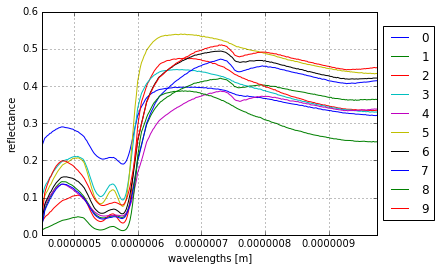

In [5]:
# 2.1 analyse spectra - plot reflectances

# the usual settings for plotting in ipython notebooks
import matplotlib.pylab as plt
%matplotlib inline

# let's have a look at our reflectances
df["reflectances"].T.plot(kind="line")
plt.ylabel("reflectance")
plt.xlabel("wavelengths [m]")
# put legend outside of plot
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

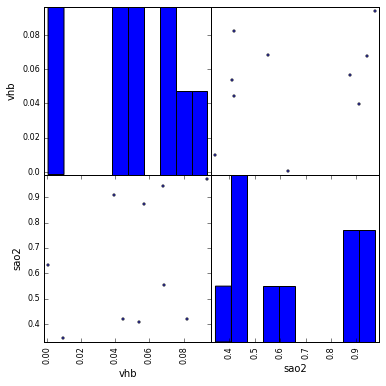

In [6]:
# 2.1 analyse spectra - show distribution of blood volume fraction (vhb) and sao2

# now we need some special pandas functions
import pandas as pd

# we're interested in the distribution of vhb and sao2 in the first layer (layer0)
df_vhb_sao2 = df["layer0"][["vhb", "sao2"]]
# plot a scatter matrix showing the distribution of vhb and sao2.
# of course, with this little data this does not really make sense,
# however it is a useful tool for analysis if much data is available
pd.tools.plotting.scatter_matrix(df_vhb_sao2, alpha=0.75, figsize=(6, 6))
plt.show()

/home/wirkert/workspace/ipcai2016_new/mc/dfmanipulations.py:34: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=11,center=True).mean()
  center=True).T


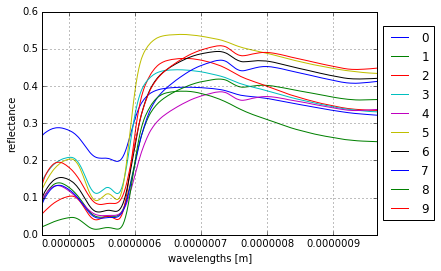

In [7]:
# 3.1 manipulate spectra - apply sliding average
# in 3.1 and 3.2 we will adapt the generated spectra to an imaginary imaging system
# This system has filters with 20nm bandwith (taken care of in 3.1)
# and takes multispectral images in 10nm steps (taken care of in 3.2)

# the module mc.dfmanipulations was written to provide some basic,
# often needed manipulations of the calculated spectra
# all dmfmanipulations are performed inplace, however, the df is also returned.
import mc.dfmanipulations as dfmani

# first copy to not loose our original data
df2 = df.copy()
# e.g. we cann apply a sliding average to our data. This is usefull if 
# we want to see e.g. how the reflectance was recorded by bands with a certain width
# a sliding average of 11 will take the five left and five right of the current reflectance
# and average. Because we take 2nm steps of reflectance in our simulation this means
# a 20nm window.
dfmani.fold_by_sliding_average(df2, 11)

# lets again plot the reflectances
df2["reflectances"].T.plot(kind="line")
plt.ylabel("reflectance")
plt.xlabel("wavelengths [m]")
# put legend outside of plot
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
# we can see that the bump at 560nm is "smoother"

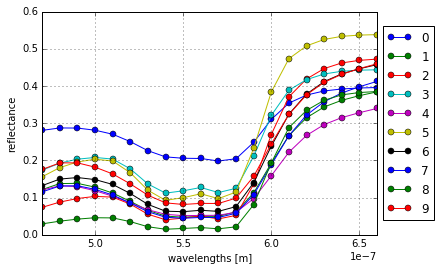

In [8]:
# 3.2 manipulate spectra - select certain wavelenghts

# our imaginary imaging system takes images in 10nm steps from 470 to 660nm
imaging_system_wavelengths = np.arange(470, 670, 10) * 10**-9

df3 = df2.copy()
dfmani.interpolate_wavelengths(df3, imaging_system_wavelengths)

# let's look at the newly created reflectances
df3["reflectances"].T.plot(kind="line", marker='o')
plt.ylabel("reflectance")
plt.xlabel("wavelengths [m]")
# put legend outside of plot
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

In [8]:
# that's it, folks, if you want, you can save the created dataframe easily to csv:
df.to_csv("results.csv", index=False)